# Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset

In [2]:
# Load dataset
file_path = "twitter_dataset.csv"
df = pd.read_csv(file_path)

# Convert Timestamp to datetime and extract features
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["Hour"] = df["Timestamp"].dt.hour
df["Day"] = df["Timestamp"].dt.day
df["Tweet_Length"] = df["Text"].apply(len)
df["Word_Count"] = df["Text"].apply(lambda x: len(x.split()))

# Data Viz.

Descriptive Statistics:
           Tweet_ID      Retweets         Likes                      Timestamp  \
count  10000.00000  10000.000000  10000.000000                          10000   
mean    5000.50000     49.721200     49.929300  2023-03-08 19:55:00.845099776   
min        1.00000      0.000000      0.000000            2023-01-01 00:01:15   
25%     2500.75000     25.000000     25.000000     2023-02-02 18:35:42.500000   
50%     5000.50000     49.000000     50.000000     2023-03-08 17:56:55.500000   
75%     7500.25000     75.000000     75.000000  2023-04-11 09:22:33.750000128   
max    10000.00000    100.000000    100.000000            2023-05-15 12:32:09   
std     2886.89568     28.948856     28.877193                            NaN   

               Hour           Day  Tweet_Length    Word_Count  
count  10000.000000  10000.000000   10000.00000  10000.000000  
mean      11.472900     14.550200     226.89360     33.985300  
min        0.000000      1.000000      83.00000     1

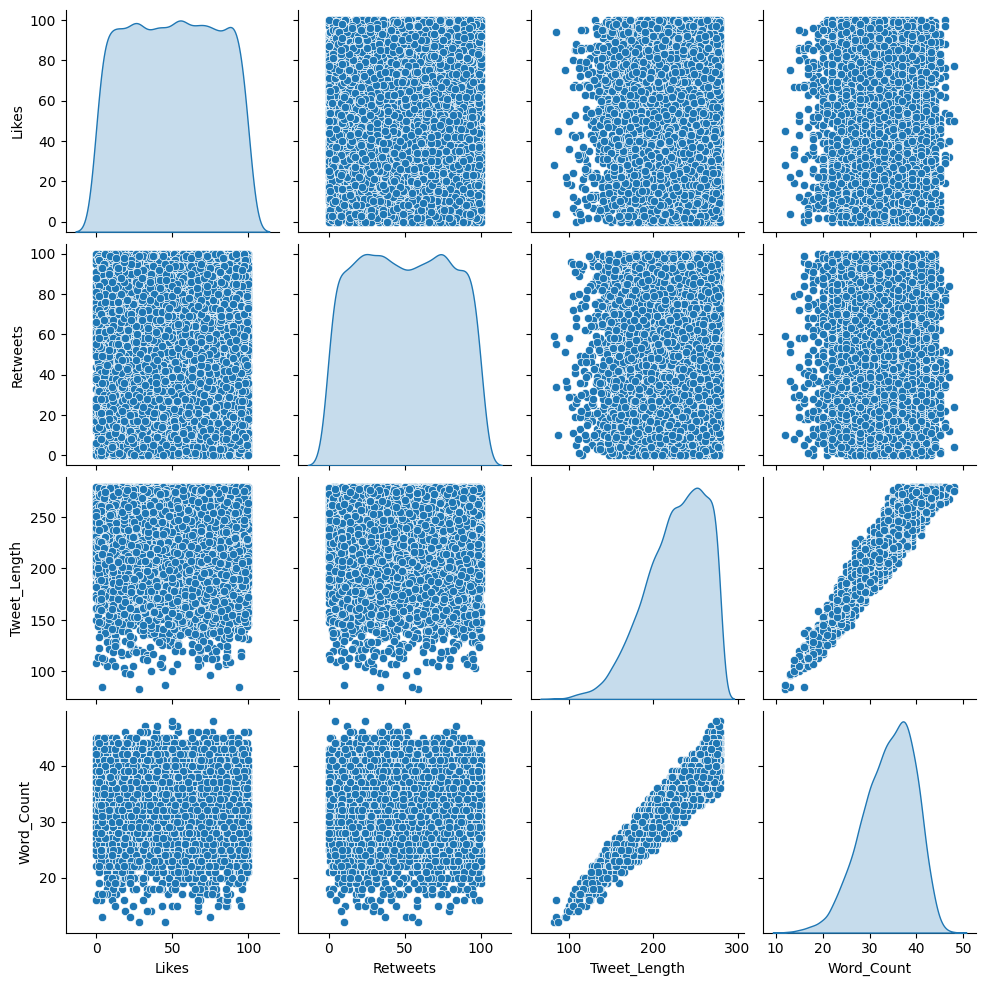

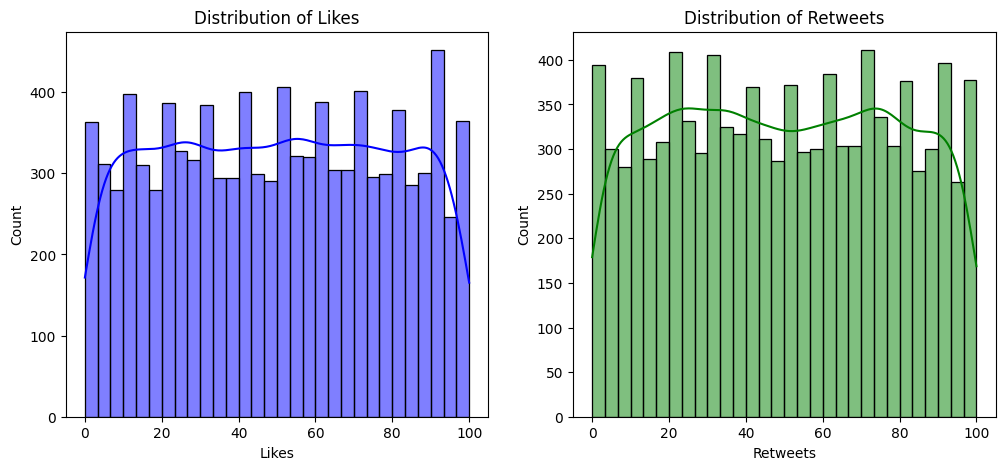

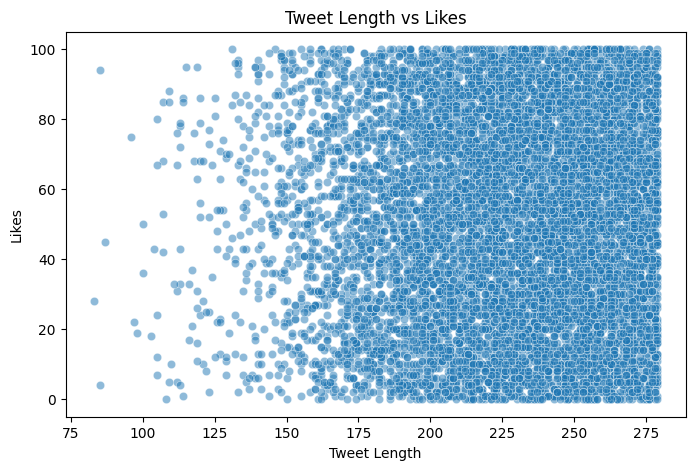

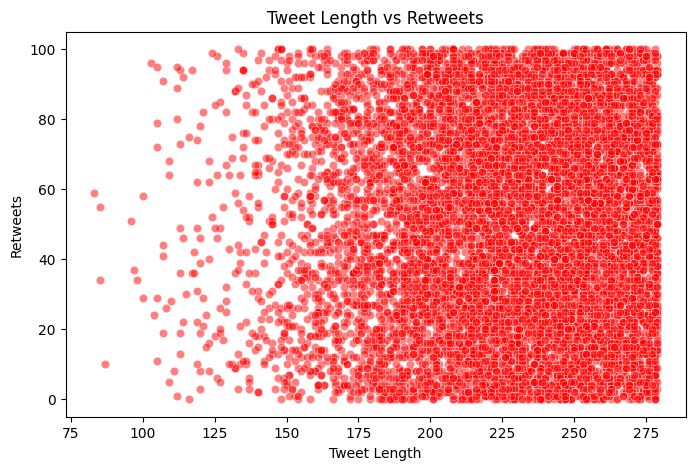

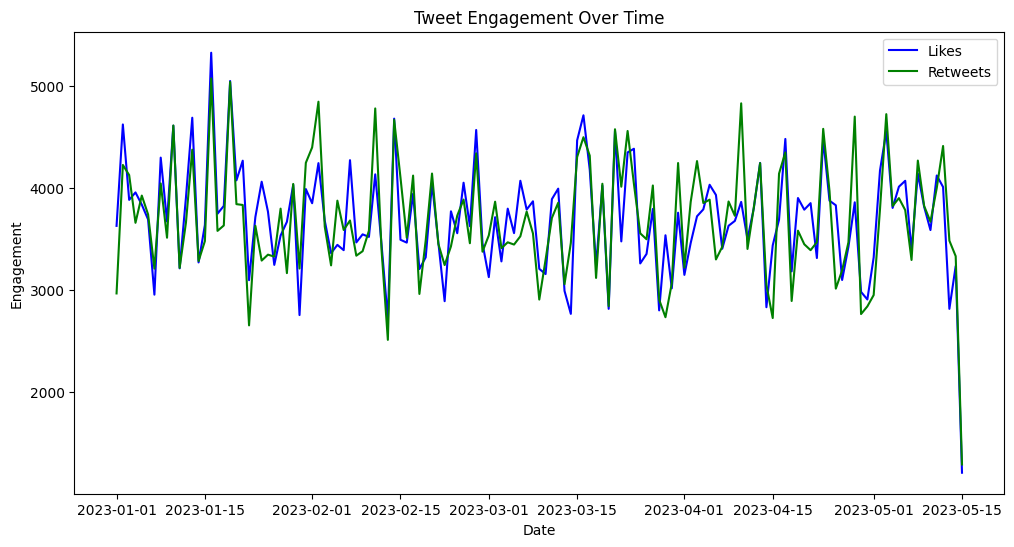

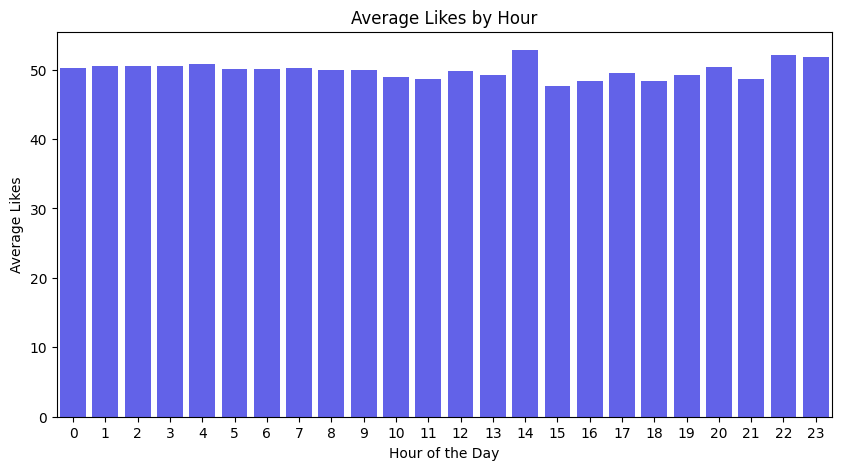

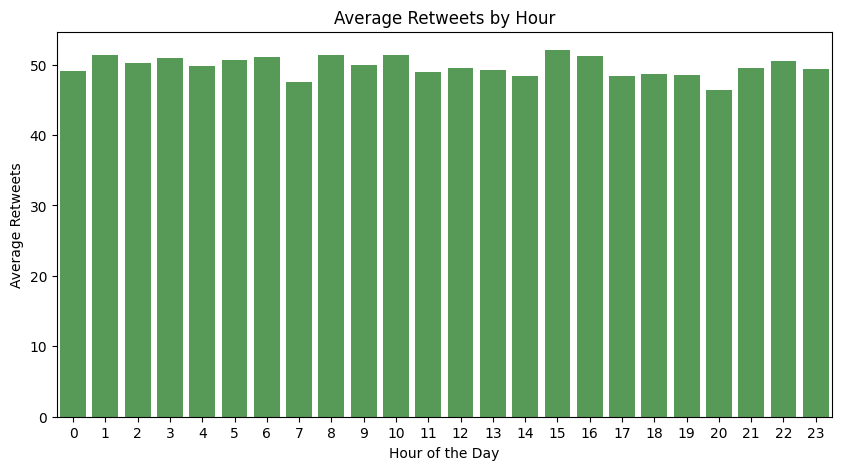

In [3]:


# Load dataset
file_path = "twitter_dataset.csv"
df = pd.read_csv(file_path)

# Convert Timestamp to datetime and extract features
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["Hour"] = df["Timestamp"].dt.hour
df["Day"] = df["Timestamp"].dt.day
df["Tweet_Length"] = df["Text"].apply(len)
df["Word_Count"] = df["Text"].apply(lambda x: len(x.split()))

# Descriptive Statistics
print("Descriptive Statistics:\n", df.describe())

# Most liked and most retweeted tweets
most_liked = df.loc[df["Likes"].idxmax()]
most_retweeted = df.loc[df["Retweets"].idxmax()]
print("Most Liked Tweet:\n", most_liked)
print("Most Retweeted Tweet:\n", most_retweeted)

# Data Visualization
sns.pairplot(df, vars=["Likes", "Retweets", "Tweet_Length", "Word_Count"], diag_kind="kde")
plt.show()

# Distribution of Likes and Retweets
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df["Likes"], bins=30, kde=True, ax=ax[0], color='blue')
ax[0].set_title("Distribution of Likes")
sns.histplot(df["Retweets"], bins=30, kde=True, ax=ax[1], color='green')
ax[1].set_title("Distribution of Retweets")
plt.show()

# Scatter plot of Tweet Length vs Likes
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["Tweet_Length"], y=df["Likes"], alpha=0.5)
plt.title("Tweet Length vs Likes")
plt.xlabel("Tweet Length")
plt.ylabel("Likes")
plt.show()

# Scatter plot of Tweet Length vs Retweets
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["Tweet_Length"], y=df["Retweets"], alpha=0.5, color='red')
plt.title("Tweet Length vs Retweets")
plt.xlabel("Tweet Length")
plt.ylabel("Retweets")
plt.show()

# Time-Series Analysis: Engagement Trends Over Time
df.set_index("Timestamp", inplace=True)
df_resampled = df.resample("D").sum()

plt.figure(figsize=(12, 6))
plt.plot(df_resampled.index, df_resampled["Likes"], label="Likes", color='blue')
plt.plot(df_resampled.index, df_resampled["Retweets"], label="Retweets", color='green')
plt.xlabel("Date")
plt.ylabel("Engagement")
plt.title("Tweet Engagement Over Time")
plt.legend()
plt.show()

# Identifying peak tweeting hours
plt.figure(figsize=(10, 5))
sns.barplot(x=df.groupby("Hour")["Likes"].mean().index, y=df.groupby("Hour")["Likes"].mean(), color='blue', alpha=0.7)
plt.xlabel("Hour of the Day")
plt.ylabel("Average Likes")
plt.title("Average Likes by Hour")
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=df.groupby("Hour")["Retweets"].mean().index, y=df.groupby("Hour")["Retweets"].mean(), color='green', alpha=0.7)
plt.xlabel("Hour of the Day")
plt.ylabel("Average Retweets")
plt.title("Average Retweets by Hour")
plt.show()


# Preprocessing

In [11]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_features = vectorizer.fit_transform(df["Text"]).toarray()
tfidf_df = pd.DataFrame(tfidf_features, columns=[f"TFIDF_{i}" for i in range(tfidf_features.shape[1])])

# Remove duplicate columns and reset index
df = df.loc[:, ~df.columns.duplicated()]
df = df.reset_index(drop=True)  # Ensure unique index

# Identifying categorical features
categorical_features = df.select_dtypes(include=["object", "category"]).columns.tolist()
if "Text" in categorical_features:
    categorical_features.remove("Text")  # Exclude text column as it's already vectorized

# One-hot encoding categorical features
if categorical_features:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_categorical = encoder.fit_transform(df[categorical_features])
    X_categorical_df = pd.DataFrame(X_categorical, columns=encoder.get_feature_names_out(categorical_features))
    df = df.drop(columns=categorical_features)
else:
    X_categorical_df = pd.DataFrame()

# Combine features
X = pd.concat([df[["Hour", "Day", "Tweet_Length", "Word_Count"]], tfidf_df], axis=1)
y_likes = df["Likes"]
y_retweets = df["Retweets"]

# Scaling numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Splitting data into training and testing sets
X_train, X_test, y_train_likes, y_test_likes = train_test_split(X, y_likes, test_size=0.2, random_state=42)
X_train, X_test, y_train_retweets, y_test_retweets = train_test_split(X, y_retweets, test_size=0.2, random_state=42)



- Scaling
- Encoding

# Training

In [12]:
# Train Linear Regression models
lr_likes = LinearRegression().fit(X_train, y_train_likes)
lr_retweets = LinearRegression().fit(X_train, y_train_retweets)

# Train Random Forest models
rf_likes = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train_likes)
rf_retweets = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train_retweets)

# Evaluation

In [13]:
# Predictions
y_pred_likes_lr = lr_likes.predict(X_test)
y_pred_retweets_lr = lr_retweets.predict(X_test)
y_pred_likes_rf = rf_likes.predict(X_test)
y_pred_retweets_rf = rf_retweets.predict(X_test)

In [14]:
# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {
        "Model": model_name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2 Score": r2
    }

In [15]:
results = [
    evaluate_model(y_test_likes, y_pred_likes_lr, "Linear Regression (Likes)"),
    evaluate_model(y_test_retweets, y_pred_retweets_lr, "Linear Regression (Retweets)"),
    evaluate_model(y_test_likes, y_pred_likes_rf, "Random Forest (Likes)"),
    evaluate_model(y_test_retweets, y_pred_retweets_rf, "Random Forest (Retweets)")
]

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df

,Model,MAE,MSE,RMSE,R2 Score
0,Linear Regression (Likes),25.994415,941.765505,30.688198,-0.108938
1,Linear Regression (Retweets),26.890601,989.434553,31.455279,-0.161465
2,Random Forest (Likes),25.469810,871.734287,29.525147,-0.026476
3,Random Forest (Retweets),25.783640,888.662090,29.810436,-0.043172
